In [41]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import requests
import json

from difflib import SequenceMatcher
import re

from tqdm import tqdm

import os
import sys
print(sys.executable)

from qa_tools.data_processing import count_answer_types_SQuAD, count_answer_types_qas, filter_question_types, is_yes_no_question
from data_utils.json_utils import read_json_file, save_json
from gotify_functions import get_gotify_token, get_gotify_url

/home/jupyter-simon_horvat/.conda/envs/simon_env/bin/python


In [2]:
MAX_LENGTH = 512
DOC_STRIDE = 256

# Get the absolute path to the project root
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Moves up from 'notebooks' to 'MB'
DATA_PATH = os.path.join(PROJECT_ROOT, "data/")

In [3]:
# Choose a Pre-trained Model
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AutoModelForSequenceClassification, pipeline

# Load deepset/xlm-roberta-large-squad2
model_name = "deepset/xlm-roberta-large-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

Some weights of the model checkpoint at deepset/xlm-roberta-large-squad2 were not used when initializing XLMRobertaForQuestionAnswering: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
path = os.path.join(PROJECT_ROOT, "synthetic_data_500_multilingual_SQuAD.json")
data = read_json_file(path)
# data = {"data": data["data"][:20]}
print(len(data["data"]))

500


In [5]:
count_answer_types_SQuAD(data["data"])

{'string': 37617, 'number': 0, 'boolean': 44307}

In [6]:
# Filtrovanie odpovedi 'number'
data = filter_question_types(data, ['number'])

In [7]:
count_answer_types_SQuAD(data["data"])

{'string': 37617, 'number': 0, 'boolean': 44307}

In [8]:
# Load data

from datasets import Dataset

dataset = Dataset.from_dict(data)
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset['train']
eval_dataset = dataset['test']

In [9]:
# # Stratifikovane rozdelenie na treningovu a testovaciu mnozinu
# from datasets import Dataset, DatasetDict
# from sklearn.model_selection import train_test_split

# # Predpokladáme, že `data` je slovník obsahujúci odpovede s atributom `answer_type`
# dataset = Dataset.from_dict(data)

# # Extrahujeme answer_type ako stratifikačnú premennú
# answer_types = [qa["answers"][0]["answer_type"] if qa["answers"] else "unknown" 
#                 for order in data["data"] 
#                 for paragraph in order["paragraphs"] 
#                 for qa in paragraph["qas"]]

# # Rozdelíme indexy stratifikovane podľa answer_type
# train_indices, test_indices = train_test_split(
#     list(range(len(dataset))), test_size=0.2, stratify=answer_types, random_state=42
# )

# # Vytvoríme nové stratifikované train/test Dataset objekty
# train_dataset = dataset.select(train_indices)
# eval_dataset = dataset.select(test_indices)

# # Vytvoríme DatasetDict pre jednoduchšiu manipuláciu
# dataset = DatasetDict({"train": train_dataset, "test": eval_dataset})

# # Skontrolujeme rozdelenie
# print(f"Train size: {len(train_dataset)}, Test size: {len(eval_dataset)}")

# Tokenizacia

In [10]:
# 0: General
# 1: True
# 2: False

# Formulovat otazky pre Yes/No tak, aby sme mali pred otazkou prikaz Odpovedaj iba Ano/Nie

def preprocess_function(examples):
    
    window_size = MAX_LENGTH

    contexts = []
    questions = []
    answers = []
    
    for order in examples['data'][:]:
        for paragraph in order['paragraphs']:
            context = paragraph["context"]
#             print(context)
            for question in paragraph["qas"]:
                question_text = question["question"]
                for answer in question['answers']: 
                    contexts.append(context)
                    questions.append(question_text)
                    answers.append(answer)
    
    
    # Tokenizacia otazky a kontextu - sliding windows with stride approach
    inputs = tokenizer(
        questions,
        contexts,
        max_length=MAX_LENGTH,
        stride=DOC_STRIDE,
        truncation=True,
        padding="max_length",
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
    )
    
    start_positions = []
    end_positions = []
#     yes_no_labels = []  # New label for Yes/No classification
    category_labels = []
    
    
    # ------------------------------
    
#     print(f"# contexts: {len(contexts)}")
#     print(f"# questions: {len(questions)}")
#     print(f"# answers: {len(answers)}")
#     print(len(inputs["offset_mapping"]))
    
    for i, offset_mapping in enumerate(inputs["offset_mapping"]):
#         print(f"Chunk {i}:")
        offset_id = inputs["overflow_to_sample_mapping"][i]
#         print(f"Offset mapping: {offset_id}")
        
        context = contexts[offset_id]
        answer = answers[offset_id]
        answer_text = answer['text']
        
#         print(f"Question: {questions[offset_id]}")
#         print(f"Answer text: {answer_text}")
#         print(f"Answer context: {context[answer_start: answer_end]}")
#         print(f"Answer start, end: {answer_start}, {answer_end}")
            
        
        # Handle Yes/No separately
        if answer_text == "True":
            start_positions.append(-1)
            end_positions.append(-1)
#             yes_no_labels.append(1)  # Yes
            category_labels.append(1)  # Yes
        elif answer_text == "False":
            start_positions.append(-1)
            end_positions.append(-1)
#             yes_no_labels.append(2)  # No
            category_labels.append(2)  # No
        else:
            answer_start = answer["answer_start"]            
            answer_end = answer_start + len(answer["text"])
            
            input_ids = inputs["input_ids"][i]
            attention_mask = inputs["attention_mask"][i]

    #         print(offset_mapping)

            sequence_ids = inputs.sequence_ids(i) # Hovori nam kde sa nachadza otazka (0) a kde kontext (1)
    #         print(sequence_ids)

            # Find the start and end in the context
            context_start = sequence_ids.index(1)
            context_end = len(sequence_ids) - 1 - sequence_ids[::-1].index(1)
    #         print(f"Context start, end: {context_start}, {context_end}")

            # Adjust start and end positions relative to the window
            window_start = offset_mapping[context_start][0]
            window_end = offset_mapping[context_end][1]
    #         print(f"Window start, end: {window_start}, {window_end}")

            # Find answer position in tokenized context
            if answer_start >= window_start and answer_end <= window_end:
                # Find the start and end token positions
                start_token = context_start
                end_token = context_end
    #             print(f"Start and end token (beginning): {start_token}, {end_token}")

                for idx, (start, end) in zip(range(start_token, end_token+1), offset_mapping[start_token: end_token+1]):
                    if start <= answer_start < end:
                        start_token = idx
                    if start < answer_end <= end:
                        end_token = idx


    #             print(f"Start and end token (end): {start_token}, {end_token}")
    #             print(f"Offset mapping start and end token: {offset_mapping[start_token]}, {offset_mapping[end_token]}")
                start_positions.append(start_token)
                end_positions.append(end_token) 
#                 yes_no_labels.append(0)  # Normal extractive answer
                category_labels.append(0)  # Normal extractive answer

    #             print(f"Window {i+1}")

            else:
                start_positions.append(-1)
                end_positions.append(-1) 
#                 yes_no_labels.append(0)  # Normal extractive answer
                category_labels.append(0)  # Normal extractive answer
    #         print("------------------------------")
        
        
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    inputs["category_labels"] = category_labels  # Add General/Yes/No label
    
#     print(inputs["start_positions"])
    
    return inputs    
 
train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
eval_dataset = eval_dataset.map(preprocess_function, batched=True, remove_columns=eval_dataset.column_names)

# train_dataset_yes_no = train_dataset_yes_no.map(preprocess_function, batched=True, remove_columns=train_dataset_yes_no.column_names, fn_kwargs={"yes_no": True})
# eval_dataset_yes_no = eval_dataset_yes_no.map(preprocess_function, batched=True, remove_columns=eval_dataset_yes_no.column_names, fn_kwargs={"yes_no": True})

# train_dataset_general = train_dataset_general.map(preprocess_function, batched=True, remove_columns=train_dataset_general.column_names, fn_kwargs={"yes_no": False})
# eval_dataset_general = eval_dataset_general.map(preprocess_function, batched=True, remove_columns=eval_dataset_general.column_names, fn_kwargs={"yes_no": False})

Parameter 'function'=<function preprocess_function at 0x7ff63e2a77f0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [11]:
sample = train_dataset[19]  # Get first sample
print(sample)
print("Question:", tokenizer.decode(sample["input_ids"]))
print("Yes/No Label:", sample["category_labels"])


{'input_ids': [0, 5282, 443, 68, 242421, 13, 104260, 13653, 32, 2, 2, 8018, 13, 38, 11853, 25, 7, 935, 6181, 2320, 12989, 59121, 237, 6083, 46876, 12, 44, 12137, 765, 142, 89014, 6181, 2320, 50336, 100, 398, 38, 1401, 3871, 10, 131, 47, 39580, 1257, 6626, 98169, 7, 1295, 67325, 425, 4265, 30318, 7, 4, 8942, 5, 99, 2668, 5016, 17721, 140429, 52486, 1549, 5098, 12221, 136, 140429, 52486, 1549, 5742, 12, 1197, 5, 581, 39580, 2037, 29823, 83, 23, 378, 115411, 268, 4, 378, 135206, 13, 268, 136, 70, 98169, 7, 621, 6626, 16530, 90, 642, 6958, 214, 10, 3622, 111, 7911, 5279, 678, 158208, 111, 4442, 3931, 1022, 2510, 3931, 1022, 4442, 3931, 12638, 5, 1401, 3871, 903, 75060, 297, 47, 884, 587, 11, 99, 4828, 172025, 237, 33662, 237, 7722, 4, 6397, 538, 390, 62, 166236, 5, 30607, 20537, 450, 642, 64209, 10, 68807, 24745, 100, 70, 131, 4, 136, 70, 4127, 7, 621, 177261, 2886, 5, 4263, 398, 765, 2499, 17582, 707, 50509, 7, 4, 22936, 2633, 1821, 3714, 3890, 30607, 20537, 450, 87, 25, 272, 99201, 70, 2

In [12]:
# for sample in train_dataset:
#     if "yes_no_labels" not in sample:
#         print("⚠️ Missing yes_no_labels in a sample!")
# for sample in eval_dataset:
#     if "yes_no_labels" not in sample:
#         print("⚠️ Missing yes_no_labels in a sample!")

In [13]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping', 'start_positions', 'end_positions', 'category_labels'],
    num_rows: 91676
})

In [14]:
len(data['data'][0]['paragraphs'][0]['qas'])
# data['data'][0]

90

In [15]:
# datasets_path = os.path.join(PROJECT_ROOT, "datasets/")

# train_path = os.path.join(datasets_path, "train_dataset_multilingual_500_SQuAD_seed_42")
# eval_path = os.path.join(datasets_path, "eval_dataset_multilingual_500_SQuAD_seed_42")

# train_dataset.save_to_disk(train_path)
# eval_dataset.save_to_disk(eval_path)

# Trenovanie modelu

In [16]:
import torch
import torch.nn as nn
from transformers import XLMRobertaForQuestionAnswering

class QAWithYesNoModel(XLMRobertaForQuestionAnswering):
    def __init__(self, config):
        super().__init__(config)
        self.boolean_classifier = nn.Linear(config.hidden_size, 3)  # General, Yes, No

    def forward(self, input_ids, attention_mask, start_positions=None, end_positions=None, category_labels=None):
        # Get the output from the base model, enabling hidden states
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, 
                                  start_positions=start_positions, end_positions=end_positions,
                                  output_hidden_states=True)  # Make sure to request hidden states
        
        # Using the [CLS] token (first token) output from the last hidden state
        sequence_output = outputs.hidden_states[-1][:, 0, :]  # Get [CLS] token representation from the last hidden state
        
        # Pass it through the yes/no classifier
        category_logits = self.boolean_classifier(sequence_output)

        loss = outputs.loss
        if category_labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            category_loss = loss_fn(category_logits, category_labels)
            loss += category_loss  # Combine losses

        return {"loss": loss, "start_logits": outputs.start_logits, "end_logits": outputs.end_logits, "category_logits": category_logits}


In [17]:
def collate_fn(batch):
    return {
        "input_ids": torch.stack([torch.tensor(x["input_ids"]) for x in batch]),
        "attention_mask": torch.stack([torch.tensor(x["attention_mask"]) for x in batch]),
        "start_positions": torch.tensor([x["start_positions"] for x in batch]),
        "end_positions": torch.tensor([x["end_positions"] for x in batch]),
        "category_labels": torch.tensor([x["category_labels"] for x in batch]),  
    }


In [24]:
# Define Training Arguments

from transformers import TrainingArguments

num_train_epochs = 5

training_args = TrainingArguments(
    output_dir="./results",
    logging_dir='./logs',  # Save logs here
#     logging_steps=10,  # Log every 10 steps
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save model at the end of each epoch
    save_total_limit=3,  # Only keep the last 3 checkpoints
    save_steps=500,
    eval_steps=500,
#     evaluation_strategy="steps",  # Ak nepoužiješ, eval sa robí len na konci epochy
#     warmup_ratio=0.1,
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="eval_loss",  # Use validation loss to determine the best model
    greater_is_better=False,  # Lower validation loss is better
    learning_rate=2e-5,
    lr_scheduler_type="cosine", # Typ scheduleru (napr. 'linear', 'cosine', 'constant')
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,  
    gradient_accumulation_steps=4,  # Simulates larger batch size
    fp16=True,  # Use mixed precision if supported by the hardware
#     device="cuda"  # Use GPU
)

In [25]:
from transformers import TrainerCallback

class GotifyCallback(TrainerCallback):
    def __init__(self, gotify_url, token):
        """
        Args:
            gotify_url (str): Base URL of your Gotify server (e.g., "http://your-gotify-server.com/message").
            token (str): Gotify app token for authentication.
        """
        self.gotify_url = gotify_url
        self.token = token
        self.history = {"epoch": [], "train_loss": [], "val_loss": []}  # Store training history


    def send_notification(self, title, message, priority=5):
        """Send a notification to Gotify."""
        payload = {
            "title": title,
            "message": message,
            "priority": priority
        }
        headers = {"X-Gotify-Key": self.token}

        try:
            response = requests.post(self.gotify_url, json=payload, headers=headers)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"⚠️ Failed to send Gotify notification: {e}")

    def on_evaluate(self, args, state, control, **kwargs):
        """Send training metrics to Gotify after evaluation."""
        if not state.log_history:
            return  # No logs available

        # Extract last log entry after evaluation
        eval_logs = state.log_history[-1]
        epoch = int(state.epoch) if state.epoch is not None else len(self.history["epoch"]) + 1
        train_loss = eval_logs.get("loss", "N/A")  # Might not be available every time
        eval_loss = eval_logs.get("eval_loss", "N/A")
        
        # Store history
        self.history["epoch"].append(epoch)
        self.history["train_loss"].append(train_loss)
        self.history["val_loss"].append(eval_loss)
        
        

        message = (f"Epoch: {state.epoch}/{num_train_epochs}\n"
                   f"Train Loss: {train_loss},\tValidation Loss: {eval_loss}")
        
        # Format message with full history
        history_message = "\n".join(
            f"Epoch {ep}: Train Loss: {tl}, Val Loss: {vl}"
            for ep, tl, vl in zip(self.history["epoch"], self.history["train_loss"], self.history["val_loss"])
        )

        self.send_notification(title="Training Update", message=message)
        self.send_notification(title="Training History Update", message=history_message)

class LossTrackerCallback(TrainerCallback):
    def __init__(self):
        self.history = {"epoch": [], "train_loss": [], "val_loss": []}

    def on_epoch_end(self, args, state, control, **kwargs):
        # Get training loss
        train_loss = state.log_history[-1].get("loss", None)  # Training loss is stored in log_history
        val_loss = state.log_history[-1].get("eval_loss", None)  # Validation loss, if available

        # Store values
        self.history["epoch"].append(state.epoch)
        self.history["train_loss"].append(train_loss)
        self.history["val_loss"].append(val_loss)

In [30]:
# # Train the Model

torch.cuda.empty_cache()

from transformers import Trainer, TrainerCallback, DataCollatorWithPadding, EarlyStoppingCallback

# model = QAWithYesNoModel.from_pretrained("xlm-roberta-base")
# model = QAWithYesNoModel.from_pretrained("deepset/xlm-roberta-large-squad2")

# Automatically select the free GPU
# # device = torch.device(get_free_gpu())
# device = torch.device("cuda:0")  # Change to "cuda:1" if you have multiple GPUs

# # Move model to the selected device
# model.to(device)
# print(f"Using device: {device}")


# Skontroluj, či model má dropout
# print(model.roberta.encoder.layer[-1].output.dropout)  

# Zmeň posledný dropout na 0.3
# model.roberta.encoder.layer[-1].output.dropout.p = 0.3

# print(model)

# # Setup Gotify callback
# gotify_url = get_gotify_url()
# gotify_token = get_gotify_token()

# # gotify_callback = GotifyCallback(gotify_url, gotify_token)
# # loss_tracker = LossTrackerCallback()

# # Train model
# trainer = Trainer(
#     model=model,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     data_collator=collate_fn,
#     args=training_args,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=3), loss_tracker, gotify_callback],
# )

trainer.train()


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [50]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

print(torch.cuda.memory_summary(device, abbreviated=True))


CUDA Available: True
Number of GPUs: 2
GPU 0: NVIDIA A100-PCIE-40GB
GPU 1: NVIDIA A100-PCIE-40GB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 15           |        cudaMalloc retries: 15        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   1090 MiB |   1090 MiB |   2181 MiB |   1090 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   1090 MiB |   1090 MiB |   2181 MiB |   1090 MiB |
|---------------------------------------------------------------------------|
| Requested memory      |   1090 MiB |   1090

Dropout(p=0.1, inplace=False)
QAWithYesNoModel(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-22): 23 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_featur

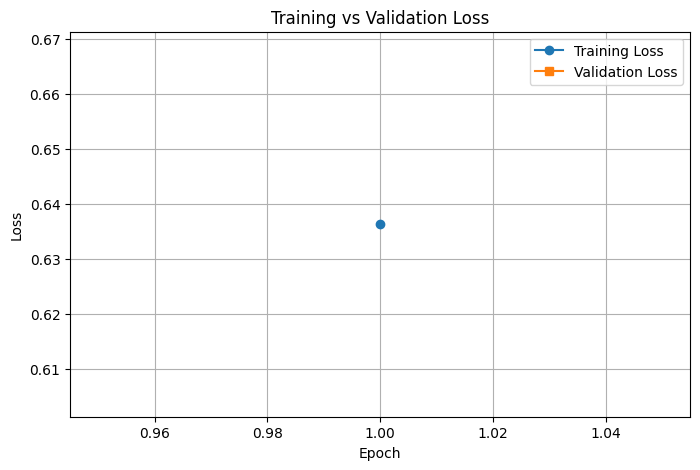

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# # Data for training and validation loss
# epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# training_loss = [1.683800, 1.153100, 0.774500, 0.575700, 0.454400, 0.408100, 0.308900, 0.366100, 0.189000, 0.147400]
# validation_loss = [1.365056, 0.985049, 0.919472, 0.885489, 0.884436, 0.958166, 0.894583, 0.842664, 0.971633, 1.044379]

# # Plot training and validation loss
# plt.figure(figsize=(8, 6))
# plt.plot(epochs, training_loss, label='Training Loss', marker='o')
# plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', linestyle='--')

# # Add labels, title, and legend
# plt.xlabel('Epoch', fontsize=12)
# plt.ylabel('Loss', fontsize=12)
# plt.title('Training and Validation Loss per Epoch', fontsize=14)
# plt.legend(fontsize=10)
# plt.grid(True)

# # Show plot
# plt.tight_layout()
# plt.show()

# Convert to Pandas DataFrame
loss_df = pd.DataFrame(loss_tracker.history)

# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(loss_df["epoch"], loss_df["train_loss"], label="Training Loss", marker="o")
plt.plot(loss_df["epoch"], loss_df["val_loss"], label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.show()


In [23]:
# Evaluate the model

metrics = trainer.evaluate()
print(metrics)

/home/jupyter-simon_horvat/.conda/envs/simon_env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.9410521388053894}


In [31]:
# model_folder = "./qa_model_general_and_boolean_multilingual"
model_folder = "./qa_model_general_and_boolean_multilingual_roberta_large_SQuAD_500_lower_lr"

In [32]:
# Export the model

model.save_pretrained(model_folder)
tokenizer.save_pretrained(model_folder)

('./qa_model_general_and_boolean_multilingual_roberta_large_SQuAD_500_lower_lr/tokenizer_config.json',
 './qa_model_general_and_boolean_multilingual_roberta_large_SQuAD_500_lower_lr/special_tokens_map.json',
 './qa_model_general_and_boolean_multilingual_roberta_large_SQuAD_500_lower_lr/sentencepiece.bpe.model',
 './qa_model_general_and_boolean_multilingual_roberta_large_SQuAD_500_lower_lr/added_tokens.json',
 './qa_model_general_and_boolean_multilingual_roberta_large_SQuAD_500_lower_lr/tokenizer.json')

# Evaluacia

In [46]:
# model_folder = "./qa_model_general_and_boolean_multilingual"
model_folder = "./qa_model_general_and_boolean_multilingual_roberta_large_lower_lr"

In [47]:
from datasets import load_from_disk
train_dataset = load_from_disk("datasets/train_dataset_general_and_boolean_multilingual_roberta_large")
eval_dataset = load_from_disk("datasets/eval_dataset_general_and_boolean_multilingual_roberta_large")

In [48]:
eval_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping', 'start_positions', 'end_positions', 'category_labels'],
    num_rows: 8658
})

In [23]:
# Rychle overenie odpovedi modelu cez pipeline - mame pristup len k textu odpovede a skore, nie ku typu odpovede
from transformers import pipeline

# Load data
with open("synthetic_data_200_SQuAD_placeholders_replaced_reformulated.json", 'r') as file:
    data = json.load(file)
    
# Initialize pipeline
# qa_pipeline = pipeline("question-answering", model=model_folder, tokenizer=model_folder, device=0)
qa_pipeline = pipeline("question-answering", model="./qa_model_yes_no", tokenizer="./qa_model_yes_no", device=0)
# qa_pipeline = pipeline("question-answering", model="./qa_model_multiling_weak", tokenizer="./qa_model_multiling_weak", device=0)


# Initialize metrics
# metric = load_metric("squad")

results = []
for i in range(10, 20):
    paragraph = data['data'][i]['paragraphs'][0]
    question = paragraph['qas'][0]
    prediction = qa_pipeline(
        question=question['question'],
        context=paragraph['context']
    )
    predicted_answer  = prediction['answer']
    print(prediction)
    print(f"Question: {question['question']}")
    print(f"Predicted Answer: {predicted_answer}")
    print(f"Actual answer: {question['answers'][0]['text']}")
    print("-------------------------------")

Device set to use cuda:0


{'score': 0.9683698415756226, 'start': 223, 'end': 233, 'answer': ' GasTerra,'}
Question: What is the name of the company that will be picking up the goods?
Predicted Answer:  GasTerra,
Actual answer: GasTerra
-------------------------------
{'score': 0.9739238619804382, 'start': 209, 'end': 253, 'answer': ' Mitsubishi on Fir 907 in Fort Worth, 79807.'}
Question: What is the pickup location for the shipment?
Predicted Answer:  Mitsubishi on Fir 907 in Fort Worth, 79807.
Actual answer: Mitsubishi on Fir 907 in Fort Worth, 79807.
-------------------------------
{'score': 0.10750935226678848, 'start': 281, 'end': 286, 'answer': ' ASAP'}
Question: What kind of request is it?
Predicted Answer:  ASAP
Actual answer: a hot pickup request
-------------------------------
{'score': 0.009223772212862968, 'start': 296, 'end': 333, 'answer': ' CHS (07646, Juniper 1159, Milwaukee)'}
Question: What is the pick-up location for the goods?
Predicted Answer:  CHS (07646, Juniper 1159, Milwaukee)
Actual an

In [30]:
# Vypisovanie vysledkov modelu na prvych X prikladoch z datoveho suboru - len logits
from transformers import AutoConfig

# Load configuration from the saved model directory
config = AutoConfig.from_pretrained(model_folder)
model = QAWithYesNoModel.from_pretrained(model_folder, config=config)

# Load data
with open("synthetic_data_200_SQuAD_placeholders_replaced_reformulated.json", 'r') as file:
    data = json.load(file)
    
data = filter_question_types(data, ['number'])

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available

for order in data["data"][:5]:
    for paragraph in order["paragraphs"]:
        context = paragraph["context"]
        for qa in paragraph["qas"]:
#             print(qa)
            question = qa["question"]
#             inputs = tokenizer(question, context, return_tensors="pt").to(device)
            inputs = tokenizer(
                question,
                context,
                max_length=MAX_LENGTH,
                stride=DOC_STRIDE,
                truncation=True,
                padding="max_length",
                return_overflowing_tokens=True,
                return_offsets_mapping=True,
                return_tensors="pt"
            ).to(device)
            
            with torch.no_grad():  # Disable gradient calculations for inference
#                 outputs = model(**inputs)
                valid_inputs = {k: v for k, v in inputs.items() if k not in ["offset_mapping", "overflow_to_sample_mapping"]}
                outputs = model(**valid_inputs)
            
#             print(outputs)

            
                
            # Extracting logits for start and end positions
            start_logits = outputs["start_logits"]  # Logits for the start position
            end_logits = outputs["end_logits"]  # Logits for the end position
            yes_no_logits = outputs["yes_no_logits"]

#             print("Start Logits:", start_logits)
#             print("End Logits:", end_logits)

            start_preds = torch.argmax(start_logits, dim=-1)
            end_preds = torch.argmax(end_logits, dim=-1)
            yes_no_preds = torch.argmax(yes_no_logits, dim=-1)
        
            print(start_preds)
            print(end_preds)
            print(yes_no_preds)
            
            print("----------------------------")

tensor([55], device='cuda:0')
tensor([70], device='cuda:0')
tensor([0], device='cuda:0')
----------------------------
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
----------------------------
tensor([93], device='cuda:0')
tensor([95], device='cuda:0')
tensor([0], device='cuda:0')
----------------------------
tensor([184], device='cuda:0')
tensor([201], device='cuda:0')
tensor([0], device='cuda:0')
----------------------------
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
----------------------------
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([1], device='cuda:0')
----------------------------
tensor([256], device='cuda:0')
tensor([257], device='cuda:0')
tensor([0], device='cuda:0')
----------------------------
tensor([93], device='cuda:0')
tensor([95], device='cuda:0')
tensor([0], device='cuda:0')
----------------------------
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')


In [31]:
# Vypisovanie vysledkov modelu na prvych X prikladoch z datoveho suboru - dekodovane logits a typ odpovede
import torch
import torch.nn.functional as F
from transformers import AutoConfig

# Load data
with open("synthetic_data_200_SQuAD_placeholders_replaced_reformulated.json", 'r') as file:
    data = json.load(file)
data = filter_question_types(data, ['number'])

# Load configuration from the saved model directory
config = AutoConfig.from_pretrained(model_folder)
model = QAWithYesNoModel.from_pretrained(model_folder, config=config)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available

answer_types = {
    0: "general",
    1: "Yes/No",
    2: "Yes/No"
}

for order in data["data"][:5]:
    for paragraph in order["paragraphs"]:
        context = paragraph["context"]
        for qa in paragraph["qas"]:
#             print(qa)
            question = qa["question"]
            actual_answer = qa["answers"][0]["text"]
#             inputs = tokenizer(question, context, return_tensors="pt").to(device)
            inputs = tokenizer(
                question,
                context,
                max_length=MAX_LENGTH,
                stride=DOC_STRIDE,
                truncation=True,
                padding="max_length",
                return_overflowing_tokens=True,
                return_offsets_mapping=True,
                return_tensors="pt"
            ).to(device)
    
#             print(inputs)
            
            with torch.no_grad():  # Disable gradient calculations for inference
#                 outputs = model(**inputs)
                valid_inputs = {k: v for k, v in inputs.items() if k not in ["offset_mapping", "overflow_to_sample_mapping"]}
                outputs = model(**valid_inputs)
            
#             print(outputs)

            all_start_logits = []
            all_end_logits = []
            all_yes_no_logits = []
            all_offset_mappings = inputs["offset_mapping"].cpu().numpy()  # Save offsets for later

            for i in range(inputs["input_ids"].shape[0]):  # Iterate over all chunks
                chunk_inputs = {key: val[i].unsqueeze(0) for key, val in inputs.items() if key not in ["offset_mapping", "overflow_to_sample_mapping"]}

                with torch.no_grad():
                    outputs = model(**chunk_inputs)

                all_start_logits.append(outputs["start_logits"][0].cpu().numpy())
                all_end_logits.append(outputs["end_logits"][0].cpu().numpy())
                all_yes_no_logits.append(outputs["yes_no_logits"][0].cpu().numpy())

            best_score = -np.inf
            best_answer = ""
            answer_type_index = 0

            for i in range(len(all_start_logits)):
                start_logits = all_start_logits[i]
                end_logits = all_end_logits[i]
                offsets = all_offset_mappings[i]
                yes_no_logits = all_yes_no_logits[i]

                # Get the best start and end indices in this chunk
                start_idx = np.argmax(start_logits)
                end_idx = np.argmax(end_logits)

                # Ensure the selected indices form a valid span
                if start_idx <= end_idx:
                    score = start_logits[start_idx] + end_logits[end_idx]
                    if score > best_score:
                        best_score = score
                        best_answer = context[offsets[start_idx][0] : offsets[end_idx][1]]  # Map to original text
                        answer_type_index = np.argmax(F.softmax(torch.tensor(yes_no_logits)))
            
            if answer_type_index == 0:
                print("Predicted Answer:", best_answer)
            else:
                print("Predicted Answer:", "True" if answer_type_index == 1 else "False")
            print("Actual Answer:", actual_answer)
            
            print("----------------------------")

/tmp/ipykernel_4122048/4178506316.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer_type_index = np.argmax(F.softmax(torch.tensor(yes_no_logits)))


Predicted Answer:  Wuhan Iron & Steel at Apple 1969 in Durham, 48348, Austria
Actual Answer: Wuhan Iron & Steel at Apple 1969 in Durham, 48348, Austria
----------------------------
Predicted Answer: 
Actual Answer: 92kg
----------------------------
Predicted Answer:  Small lorry
Actual Answer: Small lorry
----------------------------
Predicted Answer:  Robert Half International Inc. at Cypress 1271 in Washington, 23796, Afghanistan
Actual Answer: Robert Half International Inc. at Cypress 1271 in Washington, 23796, Afghanistan
----------------------------
Predicted Answer: True
Actual Answer: True
----------------------------
Predicted Answer: True
Actual Answer: True
----------------------------
Predicted Answer:  92kg
Actual Answer: 92kg
----------------------------
Predicted Answer:  Small lorry
Actual Answer: Small lorry
----------------------------
Predicted Answer: True
Actual Answer: True
----------------------------
Predicted Answer: True
Actual Answer: True
--------------------

In [32]:
# Vypisovanie vysledkov modelu na testovacom datasete

# 0: General
# 1: True
# 2: False

# Deploy and test
import torch
import torch.nn.functional as F
from transformers import AutoConfig

# Load configuration from the saved model directory
config = AutoConfig.from_pretrained(model_folder)
model = QAWithYesNoModel.from_pretrained(model_folder, config=config)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available

for idx, row in tqdm(enumerate(eval_dataset.select(range(10))), total=len(eval_dataset), desc="Evaluating"):
    
    input_ids = row['input_ids']
    attention_mask = row['attention_mask']
    offset_mapping = row['offset_mapping']
    overflow_to_sample_mapping = row['overflow_to_sample_mapping']
    start_pos = row['start_positions']
    end_pos = row['end_positions']
    offset_id = eval_dataset["overflow_to_sample_mapping"][idx]
    offset_next_id = eval_dataset["overflow_to_sample_mapping"][idx+1] if idx+1 < len(eval_dataset) else -1
                             
        
#     print(input_ids)
    inputs = {
        'input_ids': torch.tensor([input_ids]).to(device),
        'attention_mask': torch.tensor([attention_mask]).to(device),
        'offset_mapping': torch.tensor([offset_mapping]).to(device),
        'overflow_to_sample_mapping': torch.tensor([overflow_to_sample_mapping]).to(device)
    }
    
#     print(inputs)   
#     print(start_pos)
#     print(end_pos)

    ground_truth_answer = tokenizer.decode(input_ids[start_pos:end_pos+1], skip_special_tokens=True).strip()
#     print(ground_truth_answer)
    
    # Convert input IDs to context for better interpretability (if needed)
    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=False).replace('<pad>', '')
#     print(decoded_text)
    split_text = decoded_text.split('</s>')
#     print(split_text)
    # Clean and extract the question and context
    split_text = [segment.strip('</s>').strip('<s>').strip() for segment in split_text if segment.strip()]
    
    question = split_text[0]
    context = split_text[1]

    all_start_logits = []
    all_end_logits = []
    all_yes_no_logits = []
    all_offset_mappings = np.array(offset_mapping)  # Save offsets for later
#     print(torch.tensor([input_ids]).shape[0])
    for i in range(torch.tensor([input_ids]).shape[0]):  # Iterate over all chunks
        chunk_inputs = {key: val[i].unsqueeze(0).to(device) for key, val in inputs.items() if key not in ["offset_mapping", "overflow_to_sample_mapping"]}

        with torch.no_grad():
            outputs = model(**chunk_inputs)
#             print(outputs)

        all_start_logits.append(outputs["start_logits"][0].cpu().numpy())
        all_end_logits.append(outputs["end_logits"][0].cpu().numpy())
        all_yes_no_logits.append(outputs["yes_no_logits"][0].cpu().numpy())

#     print(all_start_logits)
    best_score = -np.inf
    best_answer = ""
    answer_type_index = 0

#     print(all_offset_mappings)
    
    for i in range(len(all_start_logits)):
        start_logits = all_start_logits[i]
        end_logits = all_end_logits[i]
#         offsets = all_offset_mappings[i]
        yes_no_logits = all_yes_no_logits[i]
    
        
        # Get the best start and end indices in this chunk
        start_idx = np.argmax(start_logits)
        end_idx = np.argmax(end_logits)

        # Ensure the selected indices form a valid span
        if start_idx <= end_idx:
            score = start_logits[start_idx] + end_logits[end_idx]
            if score > best_score:
                best_score = score
                best_answer = tokenizer.decode(input_ids[start_idx:end_idx+1], skip_special_tokens=True).strip()
#                 best_answer = context[all_offset_mappings[start_idx][0] : all_offset_mappings[end_idx + 1][1]]  # Map to original text
                answer_type_index = np.argmax(F.softmax(torch.tensor(yes_no_logits)))
#                 print(torch.tensor(yes_no_logits))
#                 print(answer_type_index)

    print(question)
    if answer_type_index == 0:
        print("Predicted Answer:", best_answer)
    else:
        print("Predicted Answer:", "True" if answer_type_index == 1 else "False")
    print("Actual Answer:", ground_truth_answer)

#     print(context)
#     print(start_pos)
#     print(tokenizer.decode(input_ids[start_pos:end_pos+1], skip_special_tokens=True).strip())
    print("----------------------------")

Evaluating:   0%|          | 0/8527 [00:00<?, ?it/s]/tmp/ipykernel_4122048/742149904.py:99: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer_type_index = np.argmax(F.softmax(torch.tensor(yes_no_logits)))
Evaluating:   0%|          | 8/8527 [00:00<03:48, 37.30it/s]

What are the dimensions of the pallet to be collected?
Predicted Answer: 18cm in length, 91cm in width, and 36cm in height
Actual Answer: 18cm in length, 91cm in width, and 36cm in height
----------------------------
What is the pickup location's date?
Predicted Answer: False
Actual Answer: February 4th (Friday).
----------------------------
Für welchen Wochentag ist die Abholung geplant?
Predicted Answer: February 4th (Friday).
Actual Answer: Friday
----------------------------
Pourquoi un petit camion est-il demandé pour le transport ?
Predicted Answer: Since this shipment cannot be stacked
Actual Answer: Since this shipment cannot be stacked
----------------------------
What type of trip is required for the delivery?
Predicted Answer: round trip
Actual Answer: a round trip
----------------------------
How many pallets will be collected by the driver?
Predicted Answer: one pallet
Actual Answer: one pallet
----------------------------
Wie viele Paletten holt der Fahrer ab?
Predicted A

Evaluating:   0%|          | 10/8527 [00:00<03:46, 37.57it/s]

Warum wird für den Transport ein Klein-LKW angefordert?
Predicted Answer: Since this shipment cannot be stacked, we kindly request that you allocate a small lorry for the transport. Additionally, please note that we require a round trip
Actual Answer: Since this shipment cannot be stacked
----------------------------
Quelles sont les dimensions de la palette à collecter ?
Predicted Answer: 18cm in length, 91cm in width, and 36cm in height
Actual Answer: 18cm in length, 91cm in width, and 36cm in height
----------------------------


In [37]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download stopwords once (needed for first-time use)
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')

# German + English stopwords
STOPWORDS = set(stopwords.words("english") + stopwords.words("german") + stopwords.words("french"))

[nltk_data] Downloading package stopwords to /home/jupyter-
[nltk_data]     simon_horvat/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/jupyter-
[nltk_data]     simon_horvat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jupyter-
[nltk_data]     simon_horvat/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Evaluating:   0%|          | 0/8527 [00:00<?, ?it/s]/tmp/ipykernel_4122048/246911283.py:124: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer_type_index = np.argmax(F.softmax(torch.tensor(yes_no_logits)))
Evaluating:   0%|          | 7/8527 [00:00<04:12, 33.74it/s]

What are the dimensions of the pallet to be collected?
Predicted Answer: 18cm in length, 91cm in width, and 36cm in height
Actual Answer: 18cm in length, 91cm in width, and 36cm in height
----------------------------
Question: What is the pickup location's date?
Truth:			 February 4th (Friday).
Prediction:		 
Normalized Truth:	 february 4th friday
Normalized Prediction:	 
---------------------------------
What is the pickup location's date?
Predicted Answer: False
Actual Answer: February 4th (Friday).
----------------------------
Question: Für welchen Wochentag ist die Abholung geplant?
Truth:			 Friday
Prediction:		 February 4th (Friday).
Normalized Truth:	 friday
Normalized Prediction:	 february 4th friday
---------------------------------
Für welchen Wochentag ist die Abholung geplant?
Predicted Answer: February 4th (Friday).
Actual Answer: Friday
----------------------------
Pourquoi un petit camion est-il demandé pour le transport ?
Predicted Answer: Since this shipment cannot be 

Evaluating:   0%|          | 16/8527 [00:00<03:47, 37.46it/s]

Question: Warum wird für den Transport ein Klein-LKW angefordert?
Truth:			 Since this shipment cannot be stacked
Prediction:		 Since this shipment cannot be stacked, we kindly request that you allocate a small lorry for the transport. Additionally, please note that we require a round trip
Normalized Truth:	 since shipment stacked
Normalized Prediction:	 since shipment stacked kindly request allocate small lorry transport additionally please note require round trip
---------------------------------
Warum wird für den Transport ein Klein-LKW angefordert?
Predicted Answer: Since this shipment cannot be stacked, we kindly request that you allocate a small lorry for the transport. Additionally, please note that we require a round trip
Actual Answer: Since this shipment cannot be stacked
----------------------------
Quelles sont les dimensions de la palette à collecter ?
Predicted Answer: 18cm in length, 91cm in width, and 36cm in height
Actual Answer: 18cm in length, 91cm in width, and 36c

Evaluating:   0%|          | 26/8527 [00:00<03:25, 41.30it/s]

Wann wird die Lieferung voraussichtlich am Zielort eintreffen?
Predicted Answer: February 5th (Saturday) at 23:30
Actual Answer: on February 5th (Saturday) at 23:30
----------------------------
Question: Quel jour de la semaine le ramassage est-il prévu ?
Truth:			 Friday
Prediction:		 February 4th (Friday).
Normalized Truth:	 friday
Normalized Prediction:	 february 4th friday
---------------------------------
Quel jour de la semaine le ramassage est-il prévu ?
Predicted Answer: February 4th (Friday).
Actual Answer: Friday
----------------------------
Quelle est la date du lieu de retrait ?
Predicted Answer: February 4th (Friday).
Actual Answer: February 4th (Friday).
----------------------------
Quel type de déplacement est nécessaire pour la livraison ?
Predicted Answer: a round trip
Actual Answer: a round trip
----------------------------
Question: Why is a small lorry requested for transport?
Truth:			 Since this shipment cannot be stacked
Prediction:		 Since this shipment cannot b

Evaluating:   0%|          | 36/8527 [00:00<03:13, 43.93it/s]

Combien de palettes seront collectées par le chauffeur ?
Predicted Answer: one pallet
Actual Answer: one pallet
----------------------------
Welche Abmessungen hat die abzuholende Palette?
Predicted Answer: 18cm in length, 91cm in width, and 36cm in height
Actual Answer: 18cm in length, 91cm in width, and 36cm in height
----------------------------
Was ist das Datum des Abholorts?
Predicted Answer: February 4th (Friday).
Actual Answer: February 4th (Friday).
----------------------------
What time does the collection of goods start on February 4th?
Predicted Answer: False
Actual Answer: 
----------------------------
Wann beginnt die Sammlung von Waren am 4. Februar?
Predicted Answer: False
Actual Answer: 
----------------------------
À quelle heure la collecte de marchandises commence-t-elle le 4 février?
Predicted Answer: False
Actual Answer: 
----------------------------
Is the shipment being collected from Softbank in Kansas City?
Predicted Answer: False
Actual Answer: 
-------------

Evaluating:   1%|          | 46/8527 [00:01<03:04, 46.01it/s]

Wiegt die Sendung ungefähr 100 kg?
Predicted Answer: False
Actual Answer: 
----------------------------
L'expédition pèse-t-elle environ 100 kg?
Predicted Answer: False
Actual Answer: 
----------------------------
Is a small lorry required for the transport of the shipment?
Predicted Answer: True
Actual Answer: 
----------------------------
Ist ein kleiner LKW für den Transport der Sendung benötigt?
Predicted Answer: True
Actual Answer: 
----------------------------
Un petit camion est-il requis pour le transport de l'envoi?
Predicted Answer: True
Actual Answer: 
----------------------------
Will the driver be collecting multiple pallets?
Predicted Answer: True
Actual Answer: 
----------------------------
Wird der Fahrer mehrere Paletten sammeln?
Predicted Answer: True
Actual Answer: 
----------------------------
Le conducteur collectera-t-il plusieurs palettes?
Predicted Answer: True
Actual Answer: 
----------------------------
Does the vehicle need to accommodate a round trip?
Predic

Evaluating:   1%|          | 56/8527 [00:01<02:59, 47.26it/s]

Is the delivery location in Des Moines on February 4th?
Predicted Answer: True
Actual Answer: 
----------------------------
Ist der Lieferstandort in Des Moines am 4. Februar?
Predicted Answer: True
Actual Answer: 
----------------------------
Le lieu de livraison à Des Moines est-il le 4 février?
Predicted Answer: False
Actual Answer: 
----------------------------
Can the shipment be stacked during transport?
Predicted Answer: False
Actual Answer: 
----------------------------
Kann die Sendung während des Transports gestapelt werden?
Predicted Answer: False
Actual Answer: 
----------------------------
L'envoi peut-il être empilé pendant le transport?
Predicted Answer: False
Actual Answer: 
----------------------------
Will the goods be delivered to Barclays in Greece, Des Moines on February 5th?
Predicted Answer: False
Actual Answer: 
----------------------------
Werden die Waren am 5. Februar in Griechenland, Des Moines, an Barclays geliefert?
Predicted Answer: True
Actual Answer: 
-

Evaluating:   1%|          | 66/8527 [00:01<02:57, 47.64it/s]

La collection est-elle le 4 février entre 14h45 et 07h30?
Predicted Answer: True
Actual Answer: 
----------------------------
Question: À quelle heure le véhicule doit-il être sur place pour le ramassage ?
Truth:			 zwischen dem 4. Februar 2000, 7:30 Uhr und 14:45 Uhr
Prediction:		 7:30 Uhr und 14:45 Uhr
Normalized Truth:	 4 februar 2000 730 uhr 1445 uhr
Normalized Prediction:	 730 uhr 1445 uhr
---------------------------------
À quelle heure le véhicule doit-il être sur place pour le ramassage ?
Predicted Answer: 7:30 Uhr und 14:45 Uhr
Actual Answer: zwischen dem 4. Februar 2000, 7:30 Uhr und 14:45 Uhr
----------------------------
Um welche Uhrzeit sollte die Lieferung erfolgen?
Predicted Answer: 23:30 Uhr
Actual Answer: 23:30 Uhr
----------------------------
Question: An welchem Datum soll die Abholung erfolgen?
Truth:			 4. Februar 2000,
Prediction:		 
Normalized Truth:	 4 februar 2000
Normalized Prediction:	 
---------------------------------
An welchem Datum soll die Abholung erfo

Evaluating:   1%|          | 76/8527 [00:01<02:56, 47.94it/s]

Combien pèse l'envoi ?
Predicted Answer: 82 kg
Actual Answer: 82 kg
----------------------------
Where should the shipment be delivered?
Predicted Answer: Barclays, Des Moines, 74840, Greece
Actual Answer: Barclays, Des Moines, 74840, Greece
----------------------------
Welche Art von Fahrzeug wird für den Transport benötigt?
Predicted Answer: Kleinlaster
Actual Answer: Kleinlaster
----------------------------
Question: On which date should the pickup take place?
Truth:			 4. Februar 2000,
Prediction:		 
Normalized Truth:	 4 februar 2000
Normalized Prediction:	 
---------------------------------
On which date should the pickup take place?
Predicted Answer: 
Actual Answer: 4. Februar 2000,
----------------------------
How much does the shipment weigh?
Predicted Answer: 82 kg
Actual Answer: 82 kg
----------------------------
Wie viel wiegt die Sendung?
Predicted Answer: 82 kg
Actual Answer: 82 kg
----------------------------
Question: Wo soll die Sendung abgeholt werden?
Truth:			 Kansas

Evaluating:   1%|          | 86/8527 [00:01<02:55, 48.12it/s]

Question: A quelle date doit avoir lieu le ramassage ?
Truth:			 4. Februar 2000,
Prediction:		 
Normalized Truth:	 4 februar 2000
Normalized Prediction:	 
---------------------------------
A quelle date doit avoir lieu le ramassage ?
Predicted Answer: 
Actual Answer: 4. Februar 2000,
----------------------------
Question: Où doit être récupéré l'envoi ?
Truth:			 Kansas City, 44312, Chad
Prediction:		 Softbank
Normalized Truth:	 kansas city 44312 chad
Normalized Prediction:	 softbank
---------------------------------
Où doit être récupéré l'envoi ?
Predicted Answer: Softbank
Actual Answer: Kansas City, 44312, Chad
----------------------------
What time does the collection of goods start on February 4th?
Predicted Answer: False
Actual Answer: 
----------------------------
Wann beginnt die Sammlung von Waren am 4. Februar?
Predicted Answer: False
Actual Answer: 
----------------------------
À quelle heure la collecte de marchandises commence-t-elle le 4 février?
Predicted Answer: False


Evaluating:   1%|          | 96/8527 [00:02<02:54, 48.28it/s]

L'expédition pèse-t-elle environ 100 kg?
Predicted Answer: False
Actual Answer: 
----------------------------
Is a small lorry required for the transport of the shipment?
Predicted Answer: True
Actual Answer: 
----------------------------
Ist ein kleiner LKW für den Transport der Sendung benötigt?
Predicted Answer: True
Actual Answer: 
----------------------------
Un petit camion est-il requis pour le transport de l'envoi?
Predicted Answer: True
Actual Answer: 
----------------------------
Will the driver be collecting multiple pallets?
Predicted Answer: True
Actual Answer: 
----------------------------
Wird der Fahrer mehrere Paletten sammeln?
Predicted Answer: True
Actual Answer: 
----------------------------
Le conducteur collectera-t-il plusieurs palettes?
Predicted Answer: True
Actual Answer: 
----------------------------
Does the vehicle need to accommodate a round trip?
Predicted Answer: True
Actual Answer: 
----------------------------
Muss das Fahrzeug eine Hin- und Rückfahrt 

Evaluating:   1%|          | 100/8527 [00:02<03:06, 45.11it/s]


Is the delivery location in Des Moines on February 4th?
Predicted Answer: True
Actual Answer: 
----------------------------
Average Exact Match Score: 0.83
Average F1 Score: 0.37869696969696975
Average Precision: 0.392
Average Recall: 0.3975
8527
100
6524


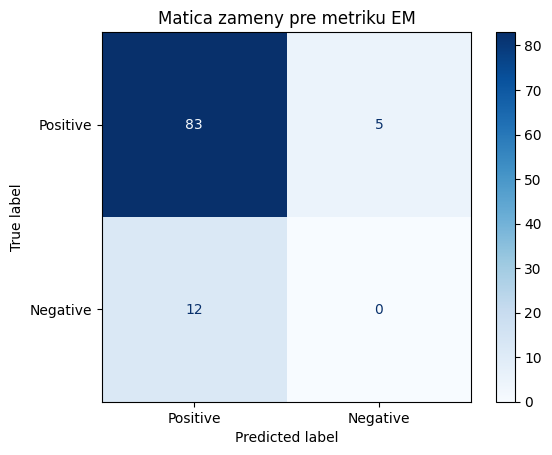

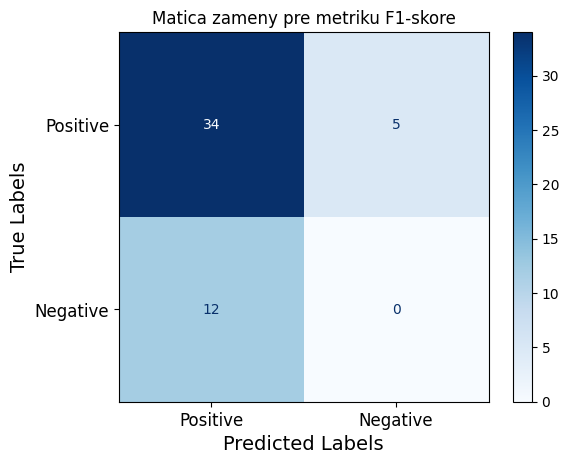

In [34]:
# Evaluacia modelu na testovacom datasete

# 0: General
# 1: True
# 2: False

# Deploy and test
import torch
import torch.nn.functional as F
from transformers import AutoConfig

from sklearn.metrics import ConfusionMatrixDisplay

# This version: 
# ✅ Removes HTML tags
# ✅ Removes punctuation (except necessary ones like parentheses, commas, colons)
# ✅ Ignores articles/prepositions (a, the, on, etc.)
# ✅ Tokenizes and lowercases words for better comparison
def normalize_text(text):
    text = re.sub(r"</?[^>]+>", "", text)  # Remove HTML tags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation (but keep alphanumeric and spaces)
    words = word_tokenize(text.lower())  # Tokenize words
    words = [word for word in words if word not in STOPWORDS]  # Remove common stopwords (like "a", "on", "the")
    return " ".join(words)

# Function to compute Exact Match (EM) score
def compute_exact_match(prediction, ground_truth):
    return int(prediction.strip().lower() == ground_truth.strip().lower())

# Function to compute F1 Score
def compute_f1(prediction, ground_truth):
    pred_tokens = prediction.strip().lower().split()
    gt_tokens = ground_truth.strip().lower().split()
    common_tokens = set(pred_tokens) & set(gt_tokens)
    if not pred_tokens or not gt_tokens:
        return 0
    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(gt_tokens)
    return (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


# Initialize lists to store metric scores
em_scores = []
f1_scores = []
precisions = []
recalls = []
CM_EM = [0,0,0,0]
CM_F1 = [0,0,0,0]

# Load configuration from the saved model directory
config = AutoConfig.from_pretrained(model_folder)
model = QAWithYesNoModel.from_pretrained(model_folder, config=config)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available

for idx, row in tqdm(enumerate(eval_dataset.select(range(100))), total=len(eval_dataset), desc="Evaluating"):
    
    input_ids = row['input_ids']
    attention_mask = row['attention_mask']
    offset_mapping = row['offset_mapping']
    overflow_to_sample_mapping = row['overflow_to_sample_mapping']
    start_pos = row['start_positions']
    end_pos = row['end_positions']
    offset_id = eval_dataset["overflow_to_sample_mapping"][idx]
    offset_next_id = eval_dataset["overflow_to_sample_mapping"][idx+1] if idx+1 < len(eval_dataset) else -1
                             
    inputs = {
        'input_ids': torch.tensor([input_ids]).to(device),
        'attention_mask': torch.tensor([attention_mask]).to(device),
        'offset_mapping': torch.tensor([offset_mapping]).to(device),
        'overflow_to_sample_mapping': torch.tensor([overflow_to_sample_mapping]).to(device)
    }


    ground_truth_answer = tokenizer.decode(input_ids[start_pos:end_pos+1], skip_special_tokens=True).strip()
    
    # Convert input IDs to context for better interpretability (if needed)
    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=False).replace('<pad>', '')
    split_text = decoded_text.split('</s>')
    # Clean and extract the question and context
    split_text = [segment.strip('</s>').strip('<s>').strip() for segment in split_text if segment.strip()]
    
    question = split_text[0]
    context = split_text[1]

    all_start_logits = []
    all_end_logits = []
    all_yes_no_logits = []
    all_offset_mappings = np.array(offset_mapping)  # Save offsets for later
    
    for i in range(torch.tensor([input_ids]).shape[0]):  # Iterate over all chunks
        chunk_inputs = {key: val[i].unsqueeze(0).to(device) for key, val in inputs.items() if key not in ["offset_mapping", "overflow_to_sample_mapping"]}

        with torch.no_grad():
            outputs = model(**chunk_inputs)

        all_start_logits.append(outputs["start_logits"][0].cpu().numpy())
        all_end_logits.append(outputs["end_logits"][0].cpu().numpy())
        all_yes_no_logits.append(outputs["yes_no_logits"][0].cpu().numpy())

    best_score = -np.inf
    best_answer = ""
    answer_type_index = 0

    
    for i in range(len(all_start_logits)):
        start_logits = all_start_logits[i]
        end_logits = all_end_logits[i]
        yes_no_logits = all_yes_no_logits[i]
    
        
        # Get the best start and end indices in this chunk
        start_idx = np.argmax(start_logits)
        end_idx = np.argmax(end_logits)

        # Ensure the selected indices form a valid span
        if start_idx <= end_idx:
            score = start_logits[start_idx] + end_logits[end_idx]
            if score > best_score:
                best_score = score
                best_answer = tokenizer.decode(input_ids[start_idx:end_idx+1], skip_special_tokens=True).strip()
                answer_type_index = np.argmax(F.softmax(torch.tensor(yes_no_logits)))

    predicted_answer = best_answer
    normalized_truth = normalize_text(ground_truth_answer)
    normalized_prediction = normalize_text(predicted_answer)
    
    # Calculate the Exact Match score
    em_score = compute_exact_match(normalized_prediction, normalized_truth)
    em_scores.append(em_score)

    # Calculate the F1 score
    f1 = compute_f1(normalized_prediction, normalized_truth)
    f1_scores.append(f1)
    
    if em_score == 0:
        print(f"Question: {question}")
        print(f"Truth:\t\t\t {ground_truth_answer}")
        print(f"Prediction:\t\t {predicted_answer}")
        print(f"Normalized Truth:\t {normalized_truth}")
        print(f"Normalized Prediction:\t {normalized_prediction}")
        print("---------------------------------")

    pred_tokens = set(normalized_prediction.lower().split())
    gt_tokens = set(normalized_truth.lower().split())

    precision = len(pred_tokens & gt_tokens) / len(pred_tokens) if pred_tokens else 0
    recall = len(pred_tokens & gt_tokens) / len(gt_tokens) if gt_tokens else 0

    precisions.append(precision)
    recalls.append(recall)
    
    # Matica zameny pre metriku CM
    if em_score == 1:
        CM_EM[0] += 1
    elif normalized_prediction:
        CM_EM[2] += 1
    elif normalized_truth:
        CM_EM[1] += 1

    # Matica zameny pre metriku F1-skore
    threshold = 0.7
    if f1 >= threshold:
        CM_F1[0] += 1
    elif normalized_prediction:
        CM_F1[2] += 1
    elif normalized_truth:
        CM_F1[1] += 1
    
    
    

    print(question)
    if answer_type_index == 0:
        print("Predicted Answer:", best_answer)
    else:
        print("Predicted Answer:", "True" if answer_type_index == 1 else "False")
    print("Actual Answer:", ground_truth_answer)
    print("----------------------------")
    
# Compute and print the overall metrics
em_score_avg = np.mean(em_scores)
f1_score_avg = np.mean(f1_scores)
precision_avg = np.mean(precisions)
recall_avg = np.mean(recalls)

print(f"Average Exact Match Score: {em_score_avg}")
print(f"Average F1 Score: {f1_score_avg}")
print(f"Average Precision: {precision_avg}")
print(f"Average Recall: {recall_avg}")

print(len(eval_dataset))
print(len(em_scores))
print(eval_dataset['overflow_to_sample_mapping'][-1])

# Matica zameny pre metriku EM
confusion_matrix = np.array(CM_EM).reshape(2,2)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Positive", "Negative"])
disp.plot(cmap="Blues")
# Add title to the confusion matrix plot
disp.ax_.set_title("Matica zameny pre metriku EM")

# Matica zameny pre metriku F1-skore
confusion_matrix = np.array(CM_F1).reshape(2,2)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Positive", "Negative"])
disp.plot(cmap="Blues")
# Add title to the confusion matrix plot
disp.ax_.set_title("Matica zameny pre metriku F1-skore")

# Increase font size of axis labels and ticks
disp.ax_.set_xlabel("Predicted Labels", fontsize=14)
disp.ax_.set_ylabel("True Labels", fontsize=14)
disp.ax_.tick_params(axis='both', which='major', labelsize=12)

Evaluating:   0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_4122048/3548684640.py:151: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer_type_index = np.argmax(F.softmax(torch.tensor(yes_no_logits)))
Evaluating: 100%|██████████| 1000/1000 [00:20<00:00, 48.35it/s]


General questions:
Average Exact Match Score: 0.707983193277311
Average F1 Score: 0.8255079530444572
Average Precision: 0.8223152880724808
Average Recall: 0.88821016285302

Boolean questions:
Average Accuracy: 0.6603053435114504
Average Precision: 0.6609848484848485
Average Recall: 0.6660954785954786
Average F1 Score: 0.657893192488263


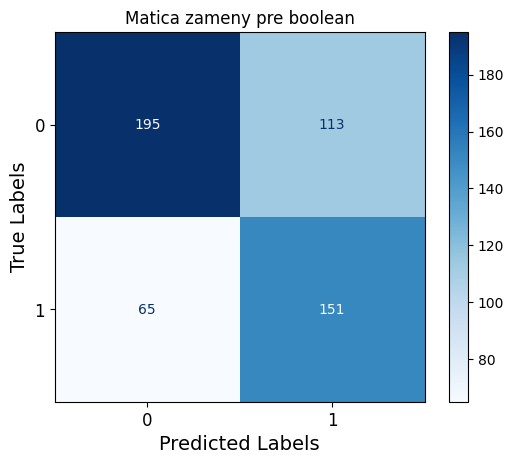

In [35]:
# Evaluacia modelu na testovacom datasete - zle vysledky

# 0: General
# 1: True
# 2: False

# Deploy and test
import torch
import torch.nn.functional as F
from transformers import AutoConfig

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# This version: 
# ✅ Removes HTML tags
# ✅ Removes punctuation (except necessary ones like parentheses, commas, colons)
# ✅ Ignores articles/prepositions (a, the, on, etc.)
# ✅ Tokenizes and lowercases words for better comparison
def normalize_text(text):
    text = re.sub(r"</?[^>]+>", "", text)  # Remove HTML tags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation (but keep alphanumeric and spaces)
    words = word_tokenize(text.lower())  # Tokenize words
    words = [word for word in words if word not in STOPWORDS]  # Remove common stopwords (like "a", "on", "the")
    return " ".join(words)

def compute_general_metrics(predictions, ground_truths):
    f1_scores = []
    precisions = []
    recalls = []
    
    num_of_exact_matches = sum([int(pred == truth) for pred, truth in zip(predictions, ground_truths)])
    em_score = num_of_exact_matches / len(predictions) if predictions else 0
    
    for prediction, ground_truth in zip(predictions, ground_truths):
        pred_tokens = tokenizer.tokenize(prediction)
        gt_tokens = tokenizer.tokenize(ground_truth)
        common_tokens = set(pred_tokens) & set(gt_tokens)
        if not pred_tokens or not gt_tokens:
            continue
        precision = len(common_tokens) / len(pred_tokens)
        recall = len(common_tokens) / len(gt_tokens)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append( (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0 )
        
    return {
        'em_score': em_score, 
        'f1_score': np.mean(f1_scores), 
        'precision': np.mean(precisions),
        'recall': np.mean(recalls)
    }

def compute_boolean_CM(predictions, ground_truths):
    cm = confusion_matrix(y_pred=predictions, y_true=ground_truths)
    return cm

def compute_boolean_metrics(y_pred, y_true):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')  # Môžeš zmeniť na 'micro' alebo 'weighted'
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }


# Initialize lists to store metric scores
general_predicitions = []
general_ground_truths = []

boolean_predicitions = []
boolean_ground_truths = []


# Load configuration from the saved model directory
config = AutoConfig.from_pretrained(model_folder)
model = QAWithYesNoModel.from_pretrained(model_folder, config=config)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available

num_of_examples = 1000
for idx, row in tqdm(enumerate(eval_dataset.select(range(num_of_examples))), total=num_of_examples, desc="Evaluating"):
    input_ids = row['input_ids']
    attention_mask = row['attention_mask']
    offset_mapping = row['offset_mapping']
    overflow_to_sample_mapping = row['overflow_to_sample_mapping']
    start_pos = row['start_positions']
    end_pos = row['end_positions']
    offset_id = eval_dataset["overflow_to_sample_mapping"][idx]
    offset_next_id = eval_dataset["overflow_to_sample_mapping"][idx+1] if idx+1 < len(eval_dataset) else -1
    yes_no_label = row['yes_no_labels']
#     print(yes_no_label)
                             
    inputs = {
        'input_ids': torch.tensor([input_ids]).to(device),
        'attention_mask': torch.tensor([attention_mask]).to(device),
        'offset_mapping': torch.tensor([offset_mapping]).to(device),
        'overflow_to_sample_mapping': torch.tensor([overflow_to_sample_mapping]).to(device)
    }

    ground_truth_answer = tokenizer.decode(input_ids[start_pos:end_pos+1], skip_special_tokens=True).strip()
    
    # Convert input IDs to context for better interpretability (if needed)
    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=False).replace('<pad>', '')
    split_text = decoded_text.split('</s>')
    # Clean and extract the question and context
    split_text = [segment.strip('</s>').strip('<s>').strip() for segment in split_text if segment.strip()]
    question, context = split_text[:2]

    all_start_logits = []
    all_end_logits = []
    all_yes_no_logits = []
    all_offset_mappings = np.array(offset_mapping)  # Save offsets for later
    
    for i in range(torch.tensor([input_ids]).shape[0]):  # Iterate over all chunks
        chunk_inputs = {key: val[i].unsqueeze(0).to(device) for key, val in inputs.items() if key not in ["offset_mapping", "overflow_to_sample_mapping"]}

        with torch.no_grad():
            outputs = model(**chunk_inputs)

        all_start_logits.append(outputs["start_logits"][0].cpu().numpy())
        all_end_logits.append(outputs["end_logits"][0].cpu().numpy())
        all_yes_no_logits.append(outputs["yes_no_logits"][0].cpu().numpy())

    best_score = -np.inf
    best_answer = ""
    answer_type_index = 0
    
    for i in range(len(all_start_logits)):
        start_logits = all_start_logits[i]
        end_logits = all_end_logits[i]
        yes_no_logits = all_yes_no_logits[i]
    
        
        # Get the best start and end indices in this chunk
        start_idx = np.argmax(start_logits)
        end_idx = np.argmax(end_logits)

        # Ensure the selected indices form a valid span
        if start_idx <= end_idx:
            score = start_logits[start_idx] + end_logits[end_idx]
            if score > best_score:
                best_score = score
                best_answer = tokenizer.decode(input_ids[start_idx:end_idx+1], skip_special_tokens=True).strip()
                answer_type_index = np.argmax(F.softmax(torch.tensor(yes_no_logits)))

    predicted_answer = best_answer
    normalized_truth = normalize_text(ground_truth_answer.strip())
    normalized_prediction = normalize_text(predicted_answer.strip())
    predicted_answer_type = answer_type_index

#     print(normalized_truth)
    
    if predicted_answer_type == 0:
        if yes_no_label == 0:
            general_predicitions.append(normalized_prediction)
        else:
            general_predicitions.append("")
        general_ground_truths.append(normalized_truth)
#         if normalized_prediction != normalized_truth:
#             print(question)
#             print(context)
#             print(normalized_prediction)
#             print(normalized_truth)
#             print("--------------------------------")
    else:
        if predicted_answer_type != 0:
            prediction = 1 if answer_type_index == 1 else 0
            ground_truth = 1 if yes_no_label == 1 else 0
            boolean_predicitions.append(prediction)
            boolean_ground_truths.append(ground_truth)
#             if prediction != ground_truth:
#                 print(question)
#                 print(context)
#                 print(prediction)
#                 print(ground_truth)
#                 print("---------------------------------")

# print(boolean_predicitions)
# print(boolean_ground_truths)

general_metrics = compute_general_metrics(general_predicitions, general_ground_truths)

print("General questions:")
print(f"Average Exact Match Score: {general_metrics['em_score']}")
print(f"Average F1 Score: {general_metrics['f1_score']}")
print(f"Average Precision: {general_metrics['precision']}")
print(f"Average Recall: {general_metrics['recall']}")
print()
            

# Matica zameny pre metriku EM
cm = compute_boolean_CM(boolean_predicitions, boolean_ground_truths)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
disp.ax_.set_title("Matica zameny pre boolean")
# Increase font size of axis labels and ticks
disp.ax_.set_xlabel("Predicted Labels", fontsize=14)
disp.ax_.set_ylabel("True Labels", fontsize=14)
disp.ax_.tick_params(axis='both', which='major', labelsize=12)

boolean_metrics = compute_boolean_metrics(boolean_predicitions, boolean_ground_truths)

print("Boolean questions:")
print(f"Average Accuracy: {boolean_metrics['accuracy']}")
print(f"Average Precision: {boolean_metrics['precision']}")
print(f"Average Recall: {boolean_metrics['recall']}")
print(f"Average F1 Score: {boolean_metrics['f1_score']}")

In [34]:
eval_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping', 'start_positions', 'end_positions', 'category_labels'],
    num_rows: 23022
})

In [35]:
# Evaluacia modelu na testovacom datasete - najprv kategoria a v pripade ze mame general, tak zvolime najvyssie skore v ramci danej kategorie

# 0: General
# 1: True
# 2: False

# Deploy and test
import torch
import torch.nn.functional as F
from transformers import AutoConfig

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

from collections import defaultdict

# This version: 
# ✅ Removes HTML tags
# ✅ Removes punctuation (except necessary ones like parentheses, commas, colons)
# ✅ Ignores articles/prepositions (a, the, on, etc.)
# ✅ Tokenizes and lowercases words for better comparison
def normalize_text(text):
    text = re.sub(r"</?[^>]+>", "", text)  # Remove HTML tags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation (but keep alphanumeric and spaces)
    words = word_tokenize(text.lower())  # Tokenize words
    words = [word for word in words if word not in STOPWORDS]  # Remove common stopwords (like "a", "on", "the")
    return " ".join(words)

def predict_pred_start_end(start_logits, end_logits):
    # Get the best start and end indices in this chunk
    start_idx = np.argmax(start_logits)
    end_idx = np.argmax(end_logits)
    
    best_score = -np.inf
    # Ensure the selected indices form a valid span
    if start_idx <= end_idx:
        score = start_logits[start_idx] + end_logits[end_idx]
        if score > best_score:
            best_score = score
            
    return start_idx, end_idx



# Load configuration from the saved model directory
config = AutoConfig.from_pretrained(model_folder)
model = QAWithYesNoModel.from_pretrained(model_folder, config=config)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU if available



# Vytvoríme slovník, kde kľúčom je index pôvodného príkladu (z overflow_to_sample_mapping)
# a hodnotou je zoznam predikcií z jednotlivých chunkov.
predictions_by_sample = defaultdict(list)


num_of_examples = 23000
for i, row in tqdm(enumerate(eval_dataset.select(range(num_of_examples))), total=num_of_examples, desc="Evaluating"):
# for i, row in enumerate(eval_dataset.select(range(num_of_examples))):
    # overflow_to_sample_mapping hovorí, z ktorého originálneho príkladu (páru otázka + kontext) chunk pochádza
    sample_id = row["overflow_to_sample_mapping"]
    
    input_ids = row['input_ids']
    attention_mask = row['attention_mask']
    offset_mapping = row['offset_mapping']
    overflow_to_sample_mapping = row['overflow_to_sample_mapping']
    start_pos = row['start_positions']
    end_pos = row['end_positions']
#     offset_id = eval_dataset["overflow_to_sample_mapping"][idx]
#     offset_next_id = eval_dataset["overflow_to_sample_mapping"][idx+1] if idx+1 < len(eval_dataset) else -1
    yes_no_label = row['category_labels']
                             
    inputs = {
        'input_ids': torch.tensor([input_ids]).to(device),
        'attention_mask': torch.tensor([attention_mask]).to(device),
#         'offset_mapping': torch.tensor([offset_mapping]).to(device),
#         'overflow_to_sample_mapping': torch.tensor([overflow_to_sample_mapping]).to(device)
    }

    with torch.no_grad():
        outputs = model(**inputs)

    start_logits = outputs["start_logits"][0].cpu().numpy()
    end_logits = outputs["end_logits"][0].cpu().numpy()
    categoty_logits = outputs["category_logits"][0].cpu().numpy()
    
    pred_start, pred_end = predict_pred_start_end(start_logits, end_logits)
    pred_category = int(np.argmax(categoty_logits))
    
#     print(pred_start, pred_end, pred_category)
    
    # Jednoduché skóre pre chunk – súčet najvyššieho start a end logitu
    score = max(start_logits) + max(end_logits)
    category_prob = max(categoty_logits)
    
#     print(score, category_prob)
    
    predictions_by_sample[sample_id].append({
        "chunk_index": i,
        "score": score,
        "category_prob": category_prob,
        "pred_start_pos": pred_start,
        "pred_end_pos": pred_end,
        'ground_truth_start_pos': start_pos,
        'ground_truth_end_pos': end_pos,
        "pred_category": pred_category,
        "ground_truth_category": yes_no_label,
        "offset_mapping": offset_mapping,
        "input_ids": input_ids,
    })
    

# print(predictions_by_sample)

Evaluating: 100%|██████████| 23000/23000 [12:53<00:00, 29.72it/s]


General questions:
Average Exact Match Score: 0.8215388574369532
Average F1 Score: 0.9025775065183704
Average Precision: 0.9190093590829739
Average Recall: 0.9139964099854054

Boolean questions:
Average Accuracy: 0.9433291269932316
Average Precision: 0.9433701161580061
Average Recall: 0.9436673367172997
Average F1 Score: 0.9433215180058179


True

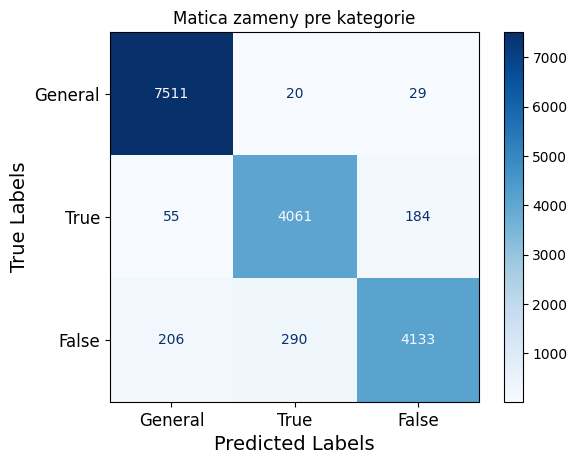

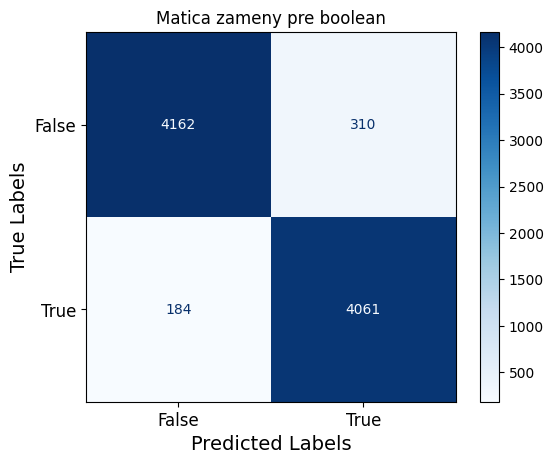

In [42]:
def compute_general_metrics(predictions, ground_truths):
    f1_scores = []
    precisions = []
    recalls = []
    
    num_of_exact_matches = sum([int(pred == truth) for pred, truth in zip(predictions, ground_truths)])
    em_score = num_of_exact_matches / len(predictions) if predictions else 0
    
    for prediction, ground_truth in zip(predictions, ground_truths):
        pred_tokens = tokenizer.tokenize(prediction)
        gt_tokens = tokenizer.tokenize(ground_truth)
        common_tokens = set(pred_tokens) & set(gt_tokens)
        if not pred_tokens or not gt_tokens:
            continue
        precision = len(common_tokens) / len(pred_tokens)
        recall = len(common_tokens) / len(gt_tokens)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append( (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0 )
        
    return {
        'em_score': em_score, 
        'f1_score': np.mean(f1_scores), 
        'precision': np.mean(precisions),
        'recall': np.mean(recalls)
    }

def compute_boolean_CM(predictions, ground_truths):
    cm = confusion_matrix(y_pred=predictions, y_true=ground_truths)
    return cm

def compute_boolean_metrics(y_pred, y_true):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')  # Môžeš zmeniť na 'micro' alebo 'weighted'
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }


# Initialize lists to store metric scores
general_predicitions = []
general_ground_truths = []

boolean_predicitions = []
boolean_ground_truths = []

predicted_category_list = []
ground_truth_category_list = []

zle_odpovede_boolean = []

for sample_id, preds in list(predictions_by_sample.items()):
    # Vyberieme chunk s najvyšším skóre
    best_pred_category = max(preds, key=lambda x: x["category_prob"])["pred_category"]
    ground_truth_category = preds[0]["ground_truth_category"]
    
    predicted_category_list.append(best_pred_category)
    ground_truth_category_list.append(ground_truth_category)
    
    if best_pred_category != 0:
        prediction = 1 if best_pred_category == 1 else 0
        ground_truth = 1 if ground_truth_category == 1 else 0
        boolean_predicitions.append(prediction)
        boolean_ground_truths.append(ground_truth)
        if prediction != ground_truth:
            
            # Convert input IDs to context for better interpretability (if needed)
            decoded_text = tokenizer.decode(preds[0]["input_ids"], skip_special_tokens=False).replace('<pad>', '')
            split_text = decoded_text.split('</s>')
            # Clean and extract the question and context
            split_text = [segment.strip('</s>').strip('<s>').strip() for segment in split_text if segment.strip()]
            question, context = split_text[:2]
#             print(f"Question: {question}")
#             print(f"Context: {context}")
#             print(f"Prediction: {prediction}")
#             print(f"Truth: {ground_truth}")
#             print("---------------------------------")
            
            odpoved = {
                "context": context,
                "question": question,
                "predicted_answer": prediction,
                "ground_truth_answer": ground_truth
            }
            zle_odpovede_boolean.append(odpoved)
#             print(f"Question: {question}")
#             print(f"Context: {context}")
#             print(f"Prediction: {prediction}")
#             print(f"Truth: {ground_truth}")
#             print("-----------------------
    else:
        best_pred = max(preds, key=lambda x: x["score"])
        input_ids = best_pred["input_ids"]
        pred_start_pos = best_pred["pred_start_pos"]
        pred_end_pos = best_pred["pred_end_pos"]
        
        ground_truth_start_pos = best_pred["ground_truth_start_pos"]
        ground_truth_end_pos = best_pred["ground_truth_end_pos"]
        
#         print(pred_start, pred_end)
#         print(pred_start_pos, pred_end_pos)
#         print(ground_truth_start_pos, ground_truth_end_pos)
        
        pred_answer = tokenizer.decode(input_ids[pred_start_pos:pred_end_pos+1], skip_special_tokens=True).strip()
        ground_truth_answer = tokenizer.decode(input_ids[ground_truth_start_pos:ground_truth_end_pos+1], skip_special_tokens=True).strip()
    
        # Convert input IDs to context for better interpretability (if needed)
        decoded_text = tokenizer.decode(input_ids, skip_special_tokens=False).replace('<pad>', '')
        split_text = decoded_text.split('</s>')
        # Clean and extract the question and context
        split_text = [segment.strip('</s>').strip('<s>').strip() for segment in split_text if segment.strip()]
        question, context = split_text[:2]
        
        normalized_truth = normalize_text(ground_truth_answer)
        normalized_prediction = normalize_text(pred_answer)
        
#         print(normalized_prediction)
#         print(normalized_truth)
        
        general_predicitions.append(normalized_prediction)
        general_ground_truths.append(normalized_truth)
        
#         if normalized_prediction != normalized_truth:
#             print(question)
#             print(context)
#             print(normalized_prediction)
#             print(normalized_truth)
#             print("--------------------------------")
    


general_metrics = compute_general_metrics(general_predicitions, general_ground_truths)

print("General questions:")
print(f"Average Exact Match Score: {general_metrics['em_score']}")
print(f"Average F1 Score: {general_metrics['f1_score']}")
print(f"Average Precision: {general_metrics['precision']}")
print(f"Average Recall: {general_metrics['recall']}")
print()
            

# Matica zameny pre kategorie
cm = compute_boolean_CM(predicted_category_list, ground_truth_category_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["General", "True", "False"])
disp.plot(cmap="Blues")
disp.ax_.set_title("Matica zameny pre kategorie")
# Increase font size of axis labels and ticks
disp.ax_.set_xlabel("Predicted Labels", fontsize=14)
disp.ax_.set_ylabel("True Labels", fontsize=14)
disp.ax_.tick_params(axis='both', which='major', labelsize=12)


# Matica zameny pre metriku boolean otazky
cm = compute_boolean_CM(boolean_predicitions, boolean_ground_truths)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False", "True"])
disp.plot(cmap="Blues")
disp.ax_.set_title("Matica zameny pre boolean")
# Increase font size of axis labels and ticks
disp.ax_.set_xlabel("Predicted Labels", fontsize=14)
disp.ax_.set_ylabel("True Labels", fontsize=14)
disp.ax_.tick_params(axis='both', which='major', labelsize=12)

boolean_metrics = compute_boolean_metrics(boolean_predicitions, boolean_ground_truths)

print("Boolean questions:")
print(f"Average Accuracy: {boolean_metrics['accuracy']}")
print(f"Average Precision: {boolean_metrics['precision']}")
print(f"Average Recall: {boolean_metrics['recall']}")
print(f"Average F1 Score: {boolean_metrics['f1_score']}")

save_json(data={"zle_odpovede": zle_odpovede_boolean}, file_path="../nespravne_predikovane_odpovede_boolean.json")

In [ ]:
import os
os._exit(0)